The goal of this work is to test several Monte Carlo methods on PLN/EUR exchange rate log returns in order to analyse exchange rate volatility over a 1-year horizon. The data is obtained via an API of the NBP (Polish National Bank). <br>
Methods tested:
<ul>
    <li>Bootstrap</li>
    <li>Geometric Brownian Motion</li>
    <li>Normal distribution</li>
    <li>Student-t distribution</li>
</ul>
It has been decided to use log returns because they are additive, so multi-step simulations are computationally simpler comparing to percentage returns. Moreover Geometric Brownian Motions are defined in terms of log returns, so they naturally fit this method. The the log return R between exchanges E at times 0 and T can be described using the formula:
$$
R_{0, T} = log(\frac{E_{T}}{E_{0}})
$$
For distribution-based approaches, firstly the data has to be fitted to the distribution. If the fit is inadequate, the distribution should not be used. Normality is assesed using tests designed to check normality, and by comparing skewness and kurtosis with the typical normal distribution's values. The Student-t fit approach is different - the fitted distribution is tested using Q-Q plot, visual inspection and parametric bootstrap Kolmogolov-Smirnov test.<br>
Each simulation is performed either by resampling returns (Bootstrap) or by generating returns from a fitted distribution (GBM, Normal, Student-t). Since exchange rates are published on business days, the simulation step count is set to 252, reflecting the approximate number of business days per year. Number of simulations per method is fixed at 1 000 000 and is arbitrary. For each method, the resulting dataset contains 1-year relative values from all simultaions. The analysis focuses on comparing 1-year returns via percentiles, statistical moments, Value at Risk (VaR), and Conditional Value at Risk (CVaR) across methods.

# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

import requests
np.set_printoptions(legacy='1.25')

# 2. Preparing data

## 2.1. Downloading and preprocessing data

In [2]:
# downloading a sample to check the data structure and potential issues
requests.get('https://api.nbp.pl/api/exchangerates/rates/a/EUR/2025-01-01/2025-01-10/').json()

{'table': 'A',
 'currency': 'euro',
 'code': 'EUR',
 'rates': [{'no': '001/A/NBP/2025',
   'effectiveDate': '2025-01-02',
   'mid': 4.2668},
  {'no': '002/A/NBP/2025', 'effectiveDate': '2025-01-03', 'mid': 4.2718},
  {'no': '003/A/NBP/2025', 'effectiveDate': '2025-01-07', 'mid': 4.2515},
  {'no': '004/A/NBP/2025', 'effectiveDate': '2025-01-08', 'mid': 4.2656},
  {'no': '005/A/NBP/2025', 'effectiveDate': '2025-01-09', 'mid': 4.2794},
  {'no': '006/A/NBP/2025', 'effectiveDate': '2025-01-10', 'mid': 4.2657}]}

In [3]:
pd.DataFrame(data=requests.get('https://api.nbp.pl/api/exchangerates/rates/a/EUR/2025-01-01/2025-01-08/').json()['rates'])

,no,effectiveDate,mid
0,001/A/NBP/2025,2025-01-02,4.2668
1,002/A/NBP/2025,2025-01-03,4.2718
2,003/A/NBP/2025,2025-01-07,4.2515
3,004/A/NBP/2025,2025-01-08,4.2656


In [4]:
#testing longer periods
requests.get('https://api.nbp.pl/api/exchangerates/rates/a/EUR/2022-01-02/2025-07-03/')

<Response [400]>

NBP API does not allow to download "longer" periods, so below exchange rates are downloaded year by year.

In [5]:
# downloading full years one by one
downloaded_df = pd.concat([pd.DataFrame(requests.get(f'https://api.nbp.pl/api/exchangerates/rates/a/EUR/{y}-01-01/{y}-12-31/').json()['rates']) for y in range(2002, 2025)])
# downloading the ongoing year
downloaded_df = pd.concat([downloaded_df, pd.DataFrame(requests.get('https://api.nbp.pl/api/exchangerates/rates/a/EUR/2025-01-01/2025-08-31/').json()['rates'])])
downloaded_df.set_index(keys='effectiveDate', inplace=True)
downloaded_df.sample(3)

,no,mid
effectiveDate,,
2003-02-27,41/A/NBP/2003,4.1965
2023-09-05,171/A/NBP/2023,4.4764
2004-03-17,54/A/NBP/2004,4.7286


In [6]:
downloaded_df.index = pd.to_datetime(downloaded_df.index)
downloaded_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5978 entries, 2002-01-02 to 2025-08-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   no      5978 non-null   object 
 1   mid     5978 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.1+ KB


In [7]:
df = downloaded_df.copy()
df['log_return'] = np.log(df['mid']/df['mid'].shift(1))
df.dropna(inplace=True)
df.head(3)

,no,mid,log_return
effectiveDate,,,
2002-01-03,2/A/NBP/2002,3.5699,0.005703
2002-01-04,3/A/NBP/2002,3.5346,-0.009937
2002-01-07,4/A/NBP/2002,3.5032,-0.008923


In [8]:
df.describe()

,mid,log_return
count,5977.000000,5977.000000
mean,4.215058,0.000031
std,0.294957,0.005246
min,3.202600,-0.045895
25%,4.063500,-0.002483
50%,4.243200,-0.000098
75%,4.390000,0.002251
max,4.964700,0.039799


## 2.2. Slicing data

The goal of this chapter is to identify <b>potential</b> structural breaks, i.e. to assess whether there is a justified need to slice the data. The analysis proceeds as follows:
<ol>
    <li>Exchange rate plot - inspect for sudden changes after which the series does not return to its previous level.</li>
    <li>Log return plot - examine revolatility clustering and extreme log returns.</li>
    <li>3-month (63-day) rolling standard deviation with thresholds plot - highlight periods of unusually high volatility.</li>
</ol>
Given the scope of the portfolio, a simpler approach is used instead of formal statistical tests. Potential structural breaks are identified by calculating the rolling standard deviation of log returns over approximately 3-month periods and comparing it against 3 thresholds defined as:
$$
threshold = mean(std(return)) + k\cdot std(return)\quad\quad for \quad k\in \{ 1, 1.5, 2 \}
$$
Periods where the log return volatility exceeds a threshold are considered potential structural breaks. The choice of k values is arbitrary, and the final decision on the presence of a structural break is made by visual inspection of the plots.

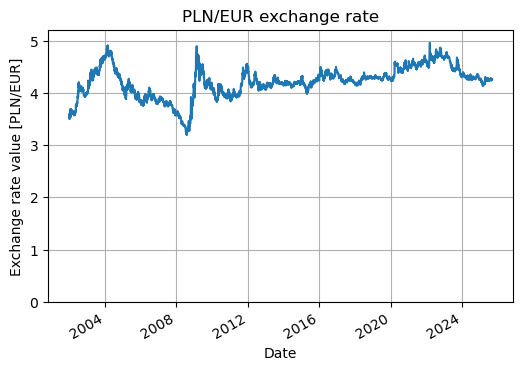

In [9]:
df['mid'].plot(ylim=(0, max(df['mid'])*1.05), figsize=(6, 4))
plt.xlabel('Date')
plt.ylabel('Exchange rate value [PLN/EUR]')
plt.title('PLN/EUR exchange rate')
plt.grid()
plt.show();

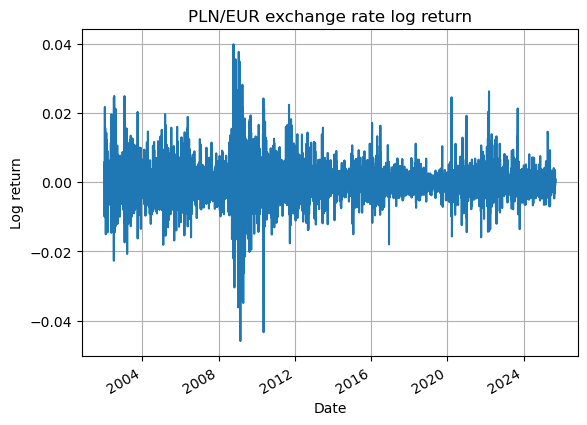

In [10]:
df['log_return'].plot()
plt.xlabel('Date')
plt.ylabel('Log return')
plt.title('PLN/EUR exchange rate log return')
plt.grid()
plt.show();

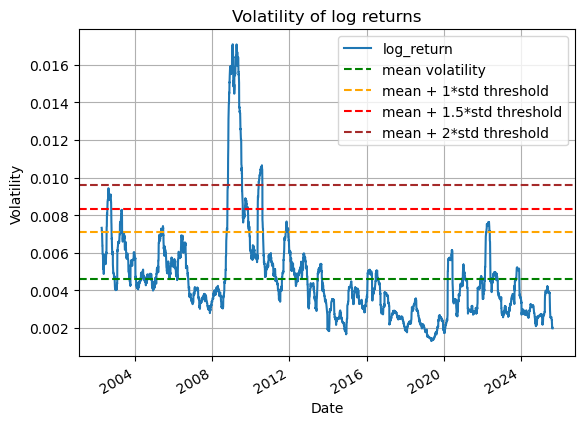

In [11]:
rol_vol = df['log_return'].rolling(63).std().dropna()
rol_mean = rol_vol.mean()
rol_std = rol_vol.std()

rol_vol.plot()
plt.axhline(rol_mean, color='green', linestyle='--', label='mean volatility')
plt.axhline(rol_mean + 1*rol_std, color='orange', linestyle='--', label='mean + 1*std threshold')
plt.axhline(rol_mean + 1.5*rol_std, color='red', linestyle='--', label='mean + 1.5*std threshold')
plt.axhline(rol_mean + 2*rol_std, color='brown', linestyle='--', label='mean + 2*std threshold')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility of log returns')
plt.grid()
plt.legend()
plt.show()

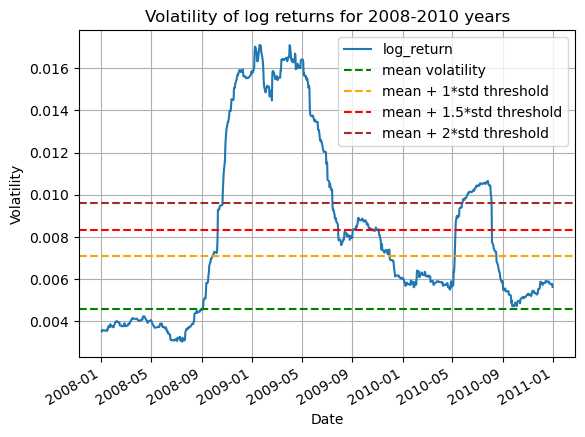

In [12]:
rol_vol.loc['2008-01-01':'2011-01-01'].plot()
plt.axhline(rol_mean, color='green', linestyle='--', label='mean volatility')
plt.axhline(rol_mean + 1*rol_std, color='orange', linestyle='--', label='mean + 1*std threshold')
plt.axhline(rol_mean + 1.5*rol_std, color='red', linestyle='--', label='mean + 1.5*std threshold')
plt.axhline(rol_mean + 2*rol_std, color='brown', linestyle='--', label='mean + 2*std threshold')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility of log returns for 2008-2010 years')
plt.grid()
plt.legend()
plt.show()

In [13]:
print('Potential structural break in 2008-2009:', 
      f'Start {rol_vol.loc[(rol_vol > rol_mean + 2*rol_std) & (rol_vol.index.year < 2010)].index[0].strftime('%Y-%m-%d')}', 
      f'End {rol_vol.loc[(rol_vol > rol_mean + 2*rol_std) & (rol_vol.index.year < 2010)].index[-1].strftime('%Y-%m-%d')}', 
      sep='\n')
print('----------------------------------------')
print('Potential structural break in 2010:', 
      f'Start {rol_vol.loc[(rol_vol > rol_mean + 2*rol_std) & (rol_vol.index.year == 2010)].index[0].strftime('%Y-%m-%d')}', 
      f'End {rol_vol.loc[(rol_vol > rol_mean + 2*rol_std) & (rol_vol.index.year == 2010)].index[-1].strftime('%Y-%m-%d')}', 
      sep='\n')

Potential structural break in 2008-2009:
Start 2008-10-22
End 2009-07-14
----------------------------------------
Potential structural break in 2010:
Start 2010-05-27
End 2010-08-04


In [14]:
df = df.loc['2010-08-05':,:]

The last huge volatility clustering incidents can be seen between 2008 and 2011. According to plots of volatility of log returns, potential structural breaks happened in 2008-2009 and 2010. By checking both time ranges, it is determined that the last potential structural break ended on 2010-08-04. Therefore, the day following that date is considered the beginning of the final dataset.

# 3. Creating models

## 3.1. Bootstrap

In [15]:
def bootstrapping(array, steps, sims, seed=123):
    '''
    array - data used in the simulation
    steps - number of steps in simulation
    sims - number of simulations
    seed - random state
    '''
    np.random.seed(seed)
# random draw with replacement
    ret = np.random.choice(array, size=steps*sims, replace=True).reshape(sims, steps)
# cummulative sum and np.exp to transform values into relative to the initial state
    paths = ret.cumsum(axis=1)
    paths = np.exp(paths)
# adding relative value of initial state (1) as the first column
    paths = np.hstack([np.ones(sims).reshape(sims, 1), paths])
    
    return paths

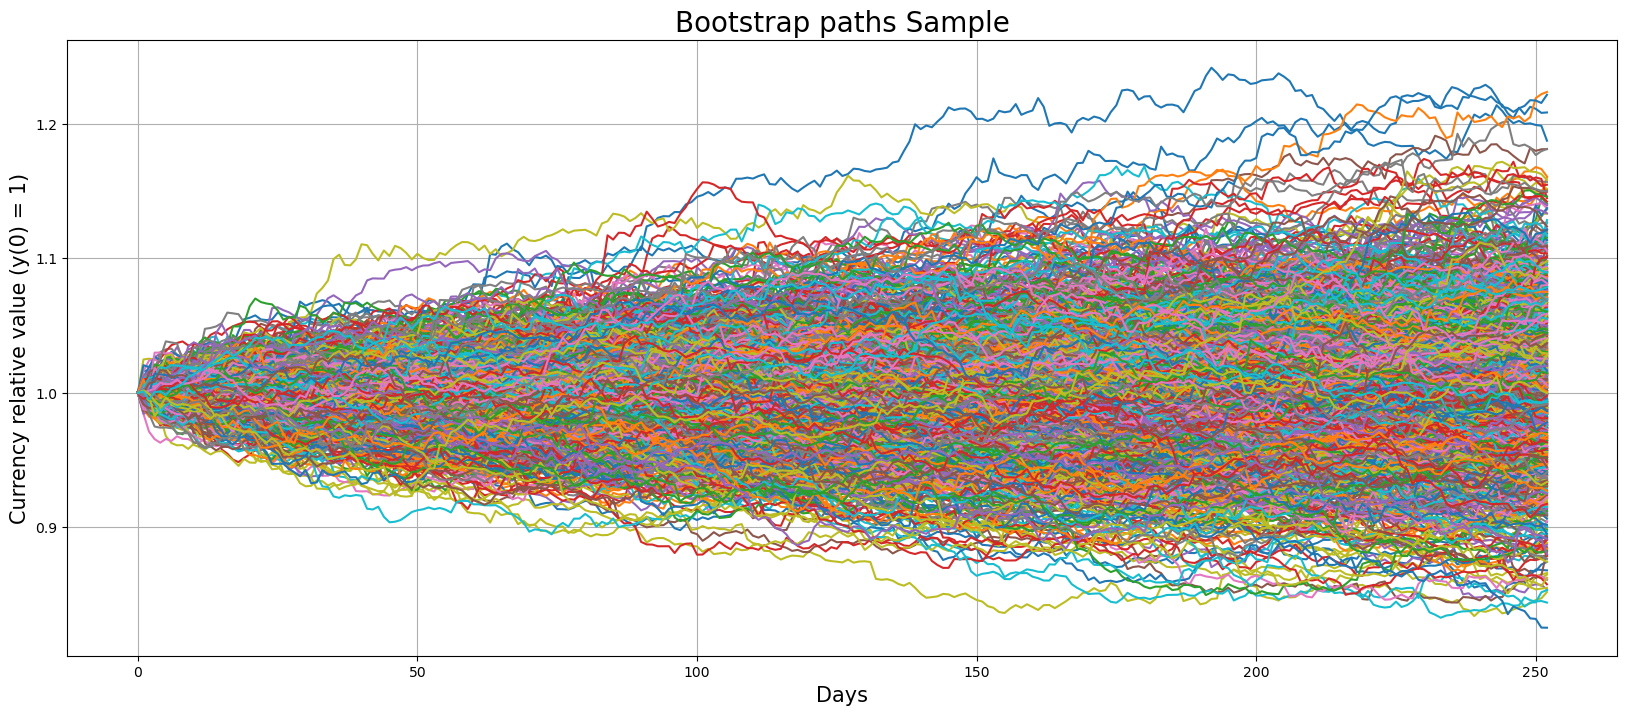

In [16]:
sample_bt = bootstrapping(array=df['log_return'], steps=252, sims=1000, seed=123)
#sample_bt = np.exp(sample_bt)
plt.figure(figsize=(20, 8))
plt.plot(sample_bt.T)
#plt.hlines(y=1, colors='gray', linestyles='solid', alpha=0.6, xmin=0, xmax=252)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Currency relative value (y(0) = 1)', fontsize=15)
plt.title('Bootstrap paths Sample', fontsize=20)
plt.grid()
plt.show()

In [17]:
bt_df = bootstrapping(array=df['log_return'], steps=252, sims=10**6, seed=123)-1
bt_df_1y = bt_df[:, -1]

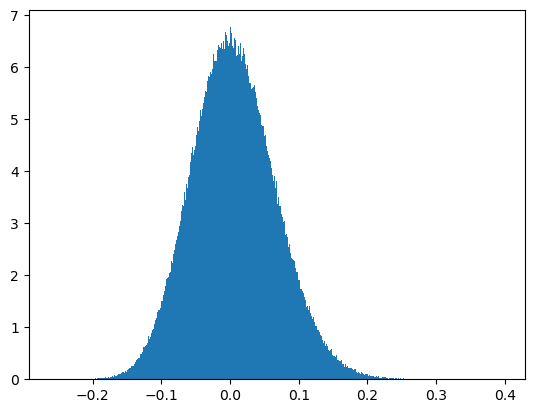

In [18]:
plt.hist(bt_df_1y, bins=1000, density=True);

In [19]:
bt_percentiles = [np.percentile(bt_df_1y, q) for q in np.arange(0, 101, 1)]

## 3.2. Geometric Brownian Motion

In [20]:
def GBM(mu, sigma, T, N, sims, seed=123):
    '''
    mu - drift parameter, usually mean value
    sigma - volataility parameter, usually standard deviation
    T - number of periods
    N - number of steps
    seed - random state
    '''
    np.random.seed(seed)

# setting step size which is number of periods divided by number of steps
    dt = T/N
    steps = np.exp(
        (mu - sigma**2/2)*dt + sigma*np.random.normal(0, np.sqrt(dt), size=(sims, N))
    )

# adding column of ones as initial state
# calculating cummulative product to each step to acquire values relative to the initial state
    paths = np.hstack([np.ones(sims).reshape(sims, 1), steps])
    paths = paths.cumprod(axis=1) 
    return paths

In [21]:
mu=np.mean(df['log_return'])
sigma=np.std(df['log_return'], ddof=0)

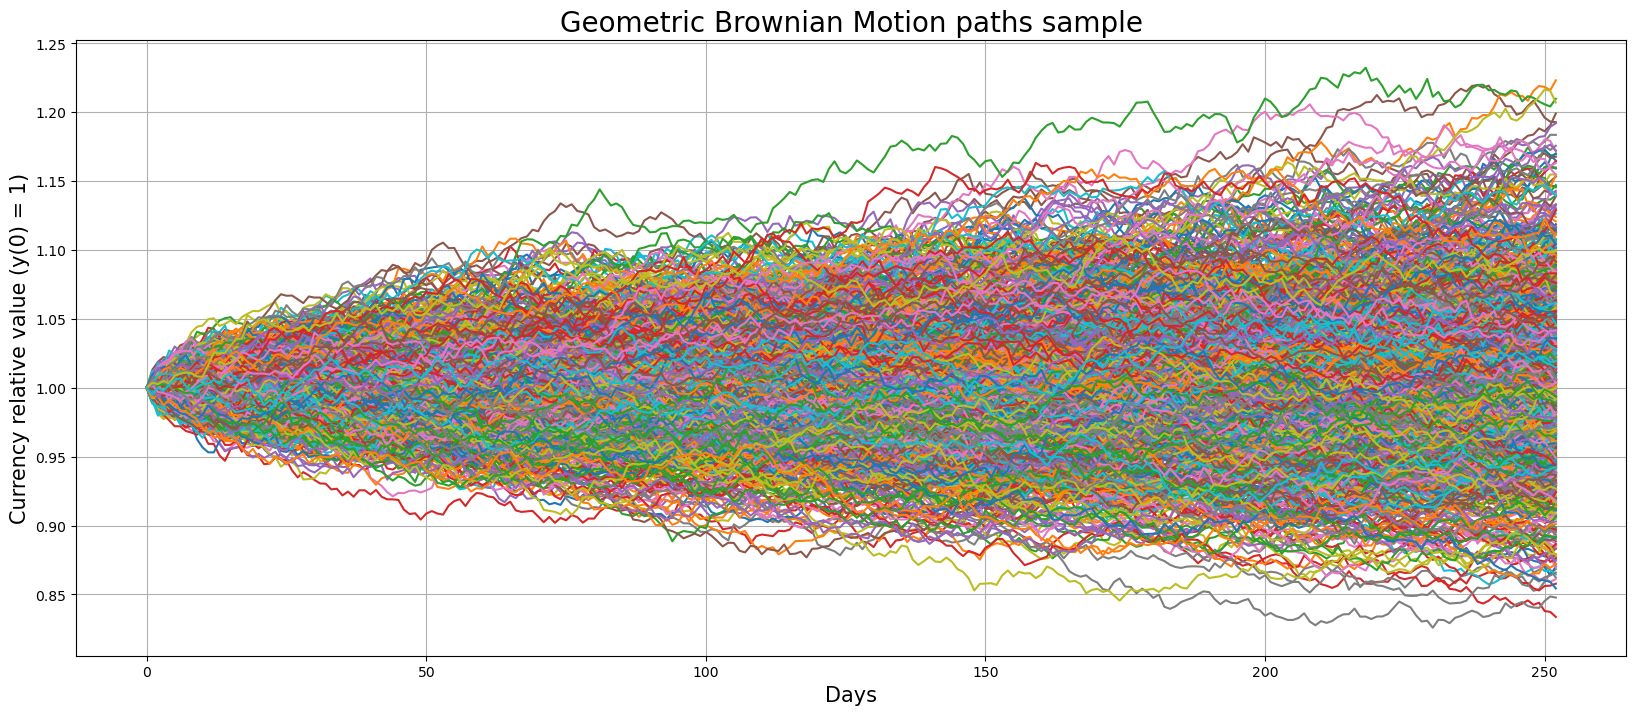

In [22]:
sample_gbm = GBM(mu=mu, sigma=sigma, T=252, N=252, sims=1000, seed=123)
#sample_bt = np.exp(sample_bt)
plt.figure(figsize=(20, 8))
plt.plot(sample_gbm.T)
#plt.hlines(y=1, colors='gray', linestyles='solid', alpha=0.6, xmin=0, xmax=252)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Currency relative value (y(0) = 1)', fontsize=15)
plt.title('Geometric Brownian Motion paths sample', fontsize=20)
plt.grid()
plt.show()

In [23]:
gbm_df = GBM(mu=np.mean(df['log_return']), sigma=np.std(df['log_return'], ddof=0), T=252, N=252, sims=10**6, seed=123)-1
gbm_df_1y = gbm_df[:, -1]

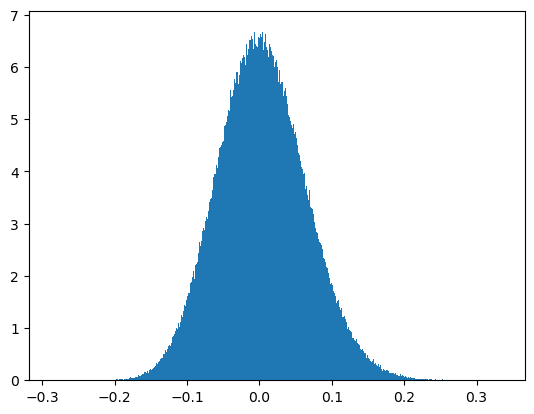

In [24]:
plt.hist(gbm_df_1y, bins=1000, density=True);

In [25]:
gbm_percentiles = [np.percentile(gbm_df_1y, q) for q in np.arange(0, 101, 1)]

## 3.3. Normal distribution

In [26]:
normal_params_comparison = pd.DataFrame(
    data={
        'stats.norm.fit MM method': list(stats.norm.fit(df['log_return'], method='MM')), 
        'stats.norm.fit MLE method': list(stats.norm.fit(df['log_return'], method='MM')), 
        'Manual MM method': [df['log_return'].mean(), df['log_return'].std()]
    },
    index=['loc', 'scale']
)
normal_params_comparison.style.format("{:.5e}")

,stats.norm.fit MM method,stats.norm.fit MLE method,Manual MM method
loc,1.57657e-05,1.57657e-05,1.57657e-05
scale,3.84517e-03,3.84517e-03,3.84567e-03


In [27]:
# generating normal distrubtion with parameters estimated using method of moments
def normal_distr(array):
    x = np.linspace(min(array), max(array), 1000)
    y = stats.norm.pdf(x, loc=array.mean(), scale=array.std())
    return x, y

# visual comparison of empirical data with normal distribution
def norm_distr_visualise(array, label):
    plt.figure(figsize=(12, 8))
    plt.hist( pd.DataFrame(array), density=True, bins=int(np.floor(len(array)**0.5)), label=label )
    x, y = normal_distr(array)
    plt.plot(x, y, label='Normal distribution')
    plt.legend(fontsize=15)
    plt.show()

# presenting normality tests results and characteristic values (3rd and 4th moments: skewness and kurtosis) 
def norm_test(array):
    skewness = stats.skew(array)
    skewtest = stats.skewtest(array)
    kurtosis = stats.kurtosis(array)
    kurttest = stats.kurtosistest(array)
    normaltest = stats.normaltest(array)
    if len(array) <= 5000:
        shapiro = stats.shapiro(array)
        is_sliced = ''
    else:
        shapiro = stats.shapiro(array[-5000:])
        is_sliced = ' (last 5000 values)'
    print(f'Skewness: {skewness}', f'Skewtest: {skewtest}', f'Kurtosis: {kurtosis}', f'Kurttest: {kurttest}', f'Normality test: {normaltest}', f'Shapiro-Wilk test{is_sliced}: {shapiro}', sep='\n')

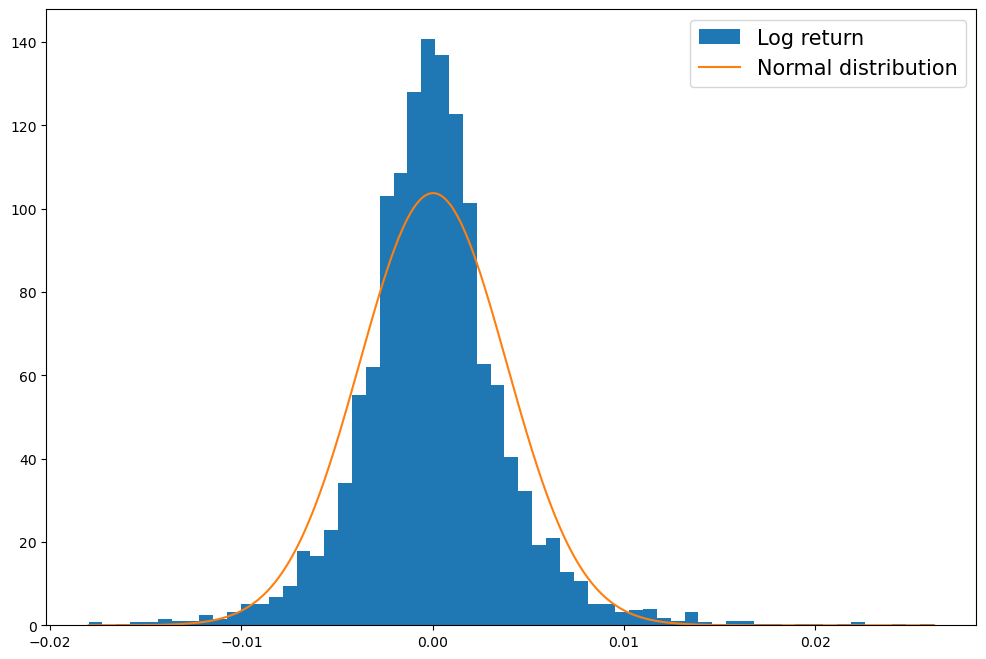

In [28]:
norm_distr_visualise(df['log_return'], 'Log return')

In [29]:
norm_test(df['log_return'])

Skewness: 0.48625062575723543
Skewtest: SkewtestResult(statistic=11.640067436343028, pvalue=2.578116894686742e-31)
Kurtosis: 4.007305246058348
Kurttest: KurtosistestResult(statistic=18.827093446324884, pvalue=4.52948674435336e-79)
Normality test: NormaltestResult(statistic=489.9506175592628, pvalue=4.060459606311019e-107)
Shapiro-Wilk test: ShapiroResult(statistic=0.9534349609200473, pvalue=3.395473128117019e-33)


It can be seen the estimated distribution does not fit the data well.
<ul>
    <li>Skewness and Kurtosis - both values are higher than the normal distribution's. Kurtosis deviates in particular which can also be seen in the histogram where the data is clearly leptokurtic (kurtosis > 0).</li>
    <li>Tests - each test's null hypothesis (consistency with the normal distribution) are rejected do to extremely low p-values which indicates the data does not come from the fitted distribution.</li>
</ul>

## 3.4. Student-t distribution

### 3.4.1. Fitting the distribution

In [30]:
deg_free, loc, scale = stats.t.fit(df['log_return'])
stats.kstest(df['log_return'], lambda x: stats.t.cdf(x=x, df=deg_free, loc=loc, scale=scale))

KstestResult(statistic=0.02575834515911135, pvalue=0.012638592260638381, statistic_location=0.0009975294576373352, statistic_sign=-1)

### 3.4.2. Q-Q plot

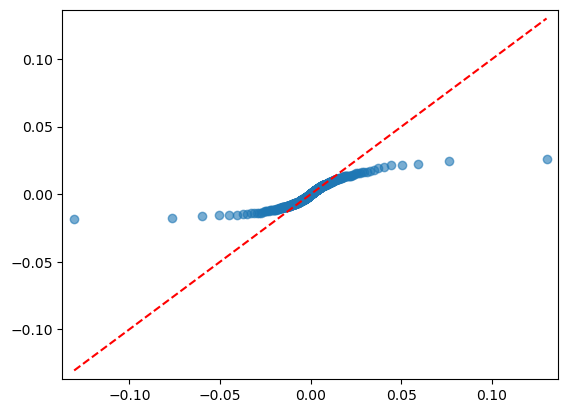

In [31]:
data_sorted = df['log_return'].sort_values(ignore_index=True)
n = len(data_sorted)
probs = (np.arange(1, n+1)-0.5)/n
studentt_ppf = stats.t.ppf(probs, df=deg_free, loc=loc, scale=scale)

plt.scatter(studentt_ppf, data_sorted, alpha=0.6, label='Data quantiles')
min_tick = min(min(studentt_ppf), min(data_sorted))
max_tick = max(max(studentt_ppf), max(data_sorted))
plt.plot([min_tick, max_tick], [min_tick, max_tick], linestyle='--', color='r', label='y=x')
plt.xlim((min_tick*1.05, max_tick*1.05))
plt.ylim((min_tick*1.05, max_tick*1.05))
plt.show()

The Student-t distribution clearly does not fit the data according to the Q-Q plot. All percentiles except middle ones deviates strongly from the distribution values.

### 3.4.3. Histogram

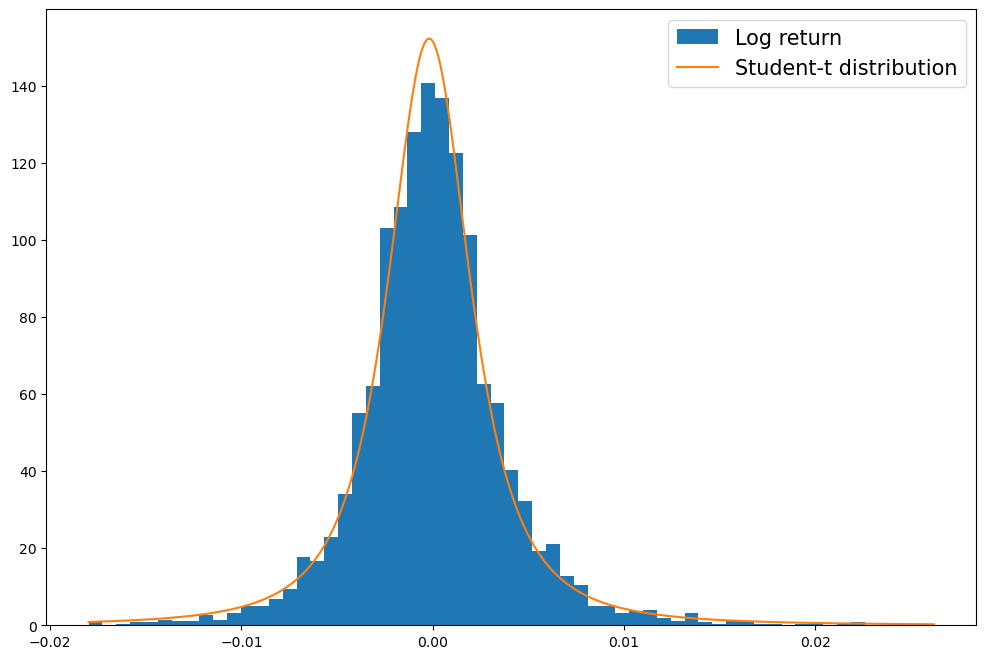

In [32]:
plt.figure(figsize=(12, 8))
plt.hist( df['log_return'], density=True, bins=int(np.floor(len(df['log_return'])**0.5)), label='Log return')
x = np.linspace(min(df['log_return']), max(df['log_return']), 1000)
y = stats.t.pdf(x=x, loc=loc, scale=scale, df=deg_free)
plt.plot(x, y, label='Student-t distribution')
plt.legend(fontsize=15)
plt.show()

In comparison to the normal distribution, the Student-t distribution's shape is closer to the histogram. However, major differences (e.g. around mode) are clearly noticeable.

### 3.4.4. Kolmogorov-Smirnov test

Comparing to the wind speed distribution project, the Kolmogorov–Smirnov (KS) test here is applied in a more rigorous way by combining it with a parametric bootstrap. The goal in this section is to answer the <i>"If the data truly came from a Student-t distribution, how unusual would it be to observe a KS statistic as large as ours?"</i> question. To answer this, many Student-t samples are simulated, each time distribution is re-fitted using sample, and their KS statistics computed. The proportion of simulated KS values exceeding the observed one gives the p-value.

In [33]:
def ks_statistic(data, deg_free, loc, scale):
    cdf = lambda x: stats.t.cdf(x=x, df=deg_free, loc=loc, scale=scale)
    return stats.kstest(data, cdf).statistic

obs_ks = ks_statistic(df['log_return'], deg_free, loc, scale)

n_boot = 1000
n = len(df['log_return'])
boot_stats = []

for _ in range(n_boot):
    sim = stats.t.rvs(deg_free, loc, scale, size=n) # simulating dataset
    df_b, loc_b, scale_b = stats.t.fit(sim) # re-fitting parameters to the simulated dataset
    boot_stats.append(ks_statistic(sim, df_b, loc_b, scale_b)) # computing KS statistic for above dataset and distribution

    if _ % 100 == 0:
        print(f'Loop no {_}')

boot_stats = np.array(boot_stats)
p_value = (np.sum(boot_stats >= obs_ks)+1) / (n_boot+1)

print("Observed KS statistic:", obs_ks)
print("Bootstrap p-value:", p_value)

Loop no 0
Loop no 100
Loop no 200
Loop no 300
Loop no 400
Loop no 500
Loop no 600
Loop no 700
Loop no 800
Loop no 900
Observed KS statistic: 0.02575834515911135
Bootstrap p-value: 0.000999000999000999


The p-value is extremely low, so it is highly unlikely the data comes from a Student-t distribution with the fitted parameters.

# 3. Accepted results analysis

## 3.1. Percentiles and moments comparison

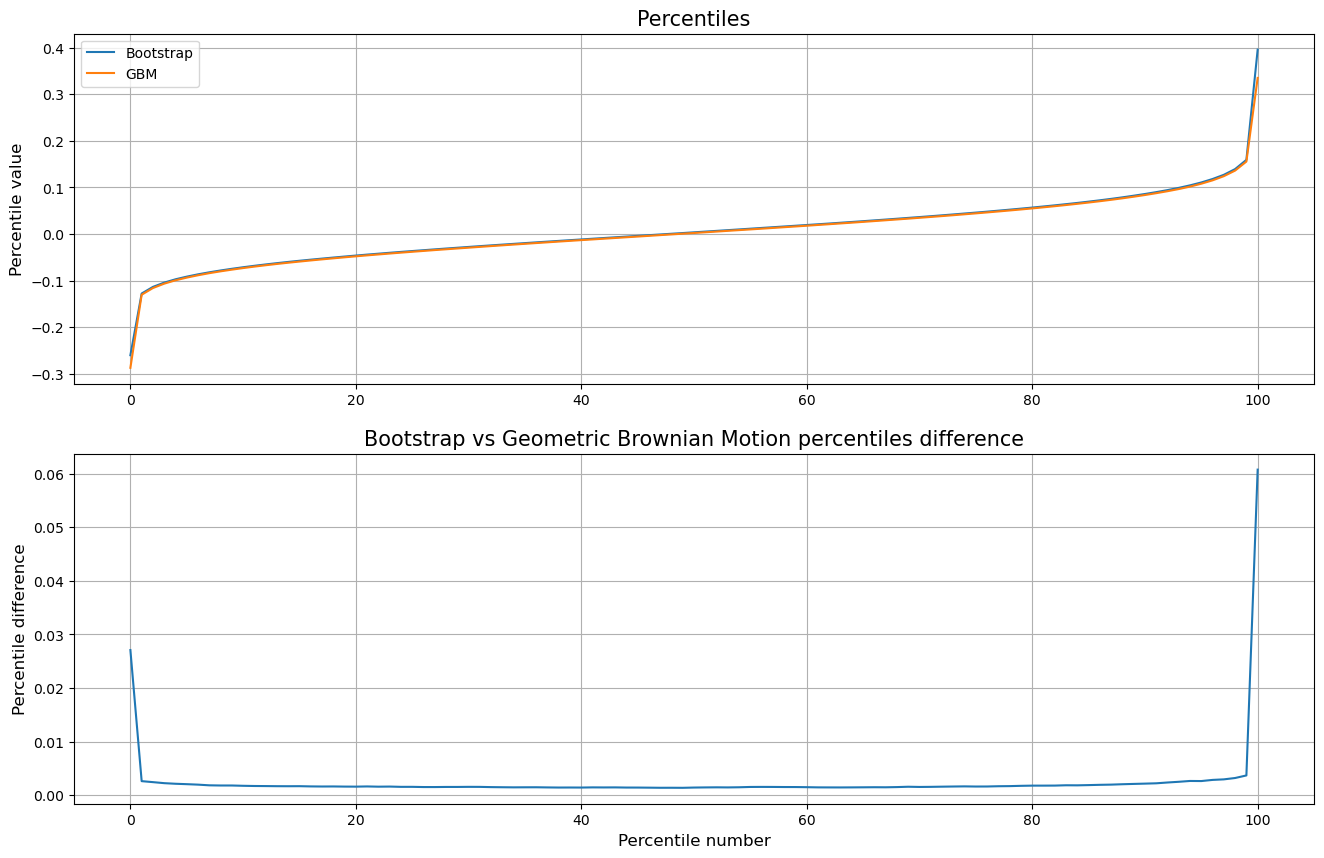

In [34]:
percentile_df = pd.DataFrame(data={'Bootstrap': bt_percentiles, 'Geometric Brownian Motion': gbm_percentiles}, index=np.arange(0, 101, 1))
percentile_df['Bootstrap vs GBM'] = percentile_df['Bootstrap'] - percentile_df['Geometric Brownian Motion']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].plot(percentile_df['Bootstrap'], label='Bootstrap')
axes[0].plot(percentile_df['Geometric Brownian Motion'], label='GBM')
axes[0].set_ylabel('Percentile value', fontsize=12)
axes[0].set_title('Percentiles', fontsize=15)
axes[0].grid()
axes[0].legend()

axes[1].plot(percentile_df['Bootstrap vs GBM'])
axes[1].set_xlabel('Percentile number', fontsize=12)
axes[1].set_ylabel('Percentile difference', fontsize=12)
axes[1].set_title('Bootstrap vs Geometric Brownian Motion percentiles difference', fontsize=15)
axes[1].grid()

plt.show()

In [35]:
quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
pd.DataFrame(
    data={'Bootstrap': np.percentile(bt_df_1y, np.array(quantiles)*100), 'Geometric Brownian Motion': np.percentile(gbm_df_1y, np.array(quantiles)*100)}, 
    index=quantiles
)

,Bootstrap,Geometric Brownian Motion
0.01,-0.127970,-0.130590
0.05,-0.091736,-0.093791
0.10,-0.071530,-0.073282
0.25,-0.036730,-0.038288
0.50,0.003496,0.002072
0.75,0.045852,0.044237
0.90,0.085802,0.083644
0.95,0.110578,0.107941
0.99,0.159181,0.155496


In [36]:
def summary(data):
    return [np.mean(data), np.std(data, ddof=0), stats.kurtosis(data), stats.skew(data)]

pd.DataFrame(data={'Bootstrap': summary(bt_df_1y), 'Geometric Brownian Motion': summary(gbm_df_1y)}, index=['mean', 'standard deviation', 'kurtosis', 'skewness'])

,Bootstrap,Geometric Brownian Motion
mean,0.005739,0.003968
standard deviation,0.061585,0.061361
kurtosis,0.107783,0.064380
skewness,0.217989,0.184029


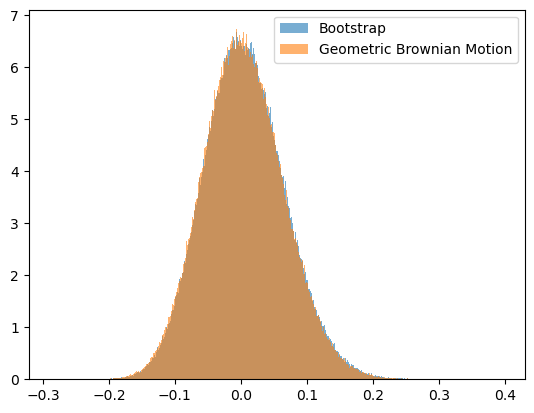

In [37]:
plt.hist(bt_df_1y, bins=1000, alpha=0.6, label='Bootstrap', density=True)
plt.hist(gbm_df_1y, bins=1000, alpha=0.6, label='Geometric Brownian Motion', density=True)
plt.legend()
plt.show()

## 3.2. Value at Risk and Conditional Value at Risk


VaR is calculated as the percentile q.<br>
On the other hand CVaR is calculated as the average value of percentiles beyond a given percentile q. Exchange rate changes can either benefit or harm a company depending on its exposure. For instance, a stronger PLN may improve results for a EUR-holding company, while a weaker PLN may worsen them (weaker PLN = less EUR after exchange). To reflect both cases, CVaR is evaluated on the lower tail (declines-oriented) for percentiles below 50 and on the upper tail (increases-oriented) for percentiles above 50.

In [38]:
def cvar_calculator(array, q):
    if q < 50:
        return array[array <= np.percentile(array, q)].mean()
    elif q > 50:
        return array[array >= np.percentile(array, q)].mean()

percentiles = [0.1,0.5,1,2.5,5,10,25,50,75,90,95,97.5,99,99.5,99.9]
var_df = pd.DataFrame(data={'VaR_Bootstrap': [np.percentile(bt_df_1y, q) for q in percentiles], 'VaR_GBM':  [np.percentile(gbm_df_1y, q) for q in percentiles]}, index=percentiles)
cvar_df = pd.DataFrame(data={'CVaR_Bootstrap': [cvar_calculator(bt_df_1y, q) for q in percentiles], 'CVaR_GBM':  [cvar_calculator(gbm_df_1y, q) for q in percentiles]}, index=percentiles)

In [39]:
var_df.join(other=cvar_df, how='outer')

,VaR_Bootstrap,VaR_GBM,CVaR_Bootstrap,CVaR_GBM
0.1,-0.167255,-0.170115,-0.181441,-0.183749
0.5,-0.140897,-0.143715,-0.157115,-0.159937
1.0,-0.127970,-0.130590,-0.145443,-0.148221
2.5,-0.108756,-0.111148,-0.128494,-0.131083
5.0,-0.091736,-0.093791,-0.113981,-0.116358
10.0,-0.071530,-0.073282,-0.097391,-0.099512
25.0,-0.036730,-0.038288,-0.070485,-0.072317
50.0,0.003496,0.002072,NaN,NaN
75.0,0.045852,0.044237,0.085722,0.083444
90.0,0.085802,0.083644,0.118767,0.115825


# 4. Discussion and conclusions

# 5. Ideas of extending the analysis